## Multiple linear regression using Hilbert transform

Written by Abirlal Metya, Panini Dasgupta, Manmeet Singh (25/12/2019)

import modules

In [6]:
# EXAMPLE of butterwidth filter


def lowpass_scipy_butter(signal1,wn,lt):
    from scipy import signal
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal



(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00,
        3.00000e+00, 2.00000e+00, 8.00000e+00, 3.00000e+00, 1.40000e+01,
        1.60000e+01, 2.10000e+01, 1.90000e+01, 3.60000e+01, 7.10000e+01,
        1.44000e+02, 2.74000e+02, 6.86000e+02, 2.44100e+03, 1.05860e+04,
        5.01940e+04, 1.43705e+05, 1.74613e+05, 8.10480e+04, 1.88870e+04,
        3.19700e+03, 4.74000e+02, 4.60000e+01, 7.00000e+00, 1.00000e+00]),
 array([-3234.211     , -3115.15162286, -2996.09224571, -2877.03286857,
        -2757.97349143, -2638.91411429, -2519.85473714, -2400.79536   ,
        -2281.73598286, -2162.67660571, -2043.61722857, -1924.55785143,
        -1805.49847429, -1686.43909714, -1567.37972   , -1448.32034286,
        -1329.26096571, -1210.20158857, -1091.14221143,  -972.08283429,
         -853.02345714,  -733.96408   ,  -614.90470286,  -495.84532571,
         -376.78594857,  -257.72657143,  -138.66719429,

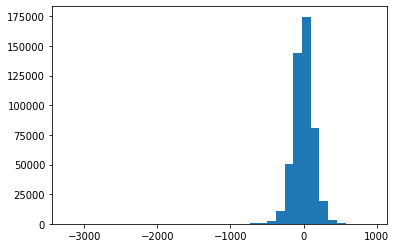

In [7]:
import pandas as pd
import matplotlib.pyplot as plt 

df       = pd.read_csv('full_data_pressure_20CRV3.txt',index_col='date')
df.index = pd.to_datetime(df.index)

plt.hist(df.values.flatten(),bins=35)

In [17]:
df[(df < df.mean() - 4*df.std())].iloc[:,0].dropna()

date
1949-12-31   -449.10938
1950-01-01   -472.56250
1985-02-05   -449.48438
1985-02-06   -473.39062
1985-02-07   -466.48438
1985-02-08   -529.97656
1985-02-09   -512.20310
1985-02-11   -473.82812
1999-03-05   -449.14062
Name: 0, dtype: float64

In [6]:
df.min()

0     -529.97656
1     -549.94530
2     -669.71875
3    -3234.21100
4     -558.57030
5     -487.14062
6    -2248.32810
7    -1949.56250
8     -432.06250
9     -477.00000
10    -456.97656
11    -538.46875
dtype: float64

In [ ]:
def data_hilbert(st,en):

    import pandas as pd
    import numpy as np
    from scipy.signal import hilbert, chirp

   ## Read Data

    df       = pd.read_csv('full_data_pressure_20CRV3.txt',index_col='date')
    df.index = pd.to_datetime(df.index)
    df=df[(df.index>=st) & (df.index<=en)]
    
    
    df2       = pd.read_csv('full_data_nn_20CR_V3.txt',index_col='date')
    df2.index = pd.to_datetime(df2.index)
    df2=df2[(df2.index>=st) & (df2.index<=en)]

    
    
    
    X = df.iloc[:,:12]
    
    def runing_mean(ddt,window=5):
        import datetime

        run  = pd.DataFrame([])
        st   = ddt.index[0]

        for i in range(1,100000):
            if (st <= ddt.index[-window]):

                dt   = ddt[(ddt.index >= st) & (ddt.index  < st+datetime.timedelta(days=window-1))]

                dtt  = pd.DataFrame(dt.mean()).T
                
                dtt['Datetime'] = st+datetime.timedelta(days= int(window/2.0))
                dtt.set_index('Datetime', inplace=True)
                run  = run.append(dtt)
                st   = st + datetime.timedelta(days=1)
                
        return run

    def rm_run_mean(ddt,window=5):
        import datetime

        run  = pd.DataFrame([])
        st   = ddt.index[0]

        for i in range(1,100000):
            if (st <= ddt.index[-window]):

                dt   = ddt[(ddt.index >= st) & (ddt.index  < st+datetime.timedelta(days=window-1))]
                dg   = dt.reset_index()
                dg   = dg.iloc[:,1:] 
                anom = dg[-1:].values - pd.DataFrame(dt.mean()).T.values
                
                dtt = pd.DataFrame(anom)

                dtt['Datetime'] = st+datetime.timedelta(days= window-1)
                dtt.set_index('Datetime', inplace=True)
                run  = run.append(dtt)
                st   = st + datetime.timedelta(days=1)

        return run

    X              = rm_run_mean(X,120)

    ## 10 days lowpass filter #######
    
    
    X1 = X.copy()
    lf = 10;wn = 3
    for i in range(X.shape[1]):
        signal = X.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        
        X1.iloc[:,i] = np.real(temp)
#     #####################################
    
    hilbertx       = pd.DataFrame(np.imag(hilbert(X1)))
    hilbertx.index = X1.index
    X2              = pd.concat([X1,hilbertx],axis=1)
    
    

    
    ################ RMM1 #########################
    y = df2.iloc[:,12:13]

#    ### 10 days lowpass #############
    y1 = y.copy()
    for i in range(y.shape[1]):
        signal = y.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        y1.iloc[:,i] = np.real(temp)
        
    RMM1 = y1.iloc[119:]
    del y,y1 

    ###################################    
        

    
    
    
     ################ RMM2 #########################
    y = df2.iloc[:,13:14]

#     ### 10 days lowpass #############
    y1 = y.copy()
    for i in range(y.shape[1]):
        signal = y.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        y1.iloc[:,i] = np.real(temp)
    RMM2 = y1.iloc[119:]
    del y,y1 
#     ###################################    
       
    

    
    return X2,RMM1,RMM2

In [ ]:
def data_pres(st,en):

    import pandas as pd
    import numpy as np
    from scipy.signal import hilbert, chirp

   ## Read Data

    df       = pd.read_csv('full_data_pressure_20CRV3.txt',index_col='date')
    df.index = pd.to_datetime(df.index)
    df=df[(df.index>=st) & (df.index<=en)]
    
    
    
    
    
    X = df.iloc[:,:12]
    
    
    def runing_mean(ddt,window=5):
        import datetime

        run  = pd.DataFrame([])
        st   = ddt.index[0]

        for i in range(1,100000):
            if (st <= ddt.index[-window]):

                dt   = ddt[(ddt.index >= st) & (ddt.index  < st+datetime.timedelta(days=window-1))]

                dtt  = pd.DataFrame(dt.mean()).T
                dtt['Datetime'] = st+datetime.timedelta(days= int(window/2.0))
                dtt.set_index('Datetime', inplace=True)
                run  = run.append(dtt)
                st   = st + datetime.timedelta(days=1)
                
        return run

    def rm_run_mean(ddt,window=5):
        import datetime

        run  = pd.DataFrame([])
        st   = ddt.index[0]

        for i in range(1,100000):
            if (st <= ddt.index[-window]):

                dt   = ddt[(ddt.index >= st) & (ddt.index  < st+datetime.timedelta(days=window-1))]
                dg   = dt.reset_index()
                dg   = dg.iloc[:,1:] 
                anom = dg[-1:].values - pd.DataFrame(dt.mean()).T.values
               
                dtt = pd.DataFrame(anom)

                dtt['Datetime'] = st+datetime.timedelta(days= window-1)
                dtt.set_index('Datetime', inplace=True)
                run  = run.append(dtt)
                st   = st + datetime.timedelta(days=1)

        return run

    X              = rm_run_mean(X,120)


    ## 10 days lowpass filter #######
    
    
    X1 = X.copy()
    lf = 10;wn =3 
    for i in range(X.shape[1]):
        signal = X.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        X1.iloc[:,i] = np.real(temp)
#     #####################################
    
    hilbertx       = pd.DataFrame(np.imag(hilbert(X1)))
    hilbertx.index = X1.index
    X2              = pd.concat([X1,hilbertx],axis=1)
    
    
    
    
    return X2

In [1]:
## EXAMPLE of butterwidth filter


# def lowpass_scipy_butter(signal1,wn,lt):
#     from scipy import signal
#     w = 2/lt # Normalize the frequency
#     b, a = signal.butter(wn, w, 'low')
#     lowpass_signal = signal.filtfilt(b, a, signal1)

#     return lowpass_signal

# def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
#     import numpy as np
#     import scipy as sc
#     from scipy import fftpack
    
#     lowpass_signal=np.zeros(signal.shape)
#     if any(np.isnan(signal)):
#         raise ValueError('There is NaN in the signal')
#     else:
#         hf = 1./time_period

#         temp_fft = sc.fftpack.fft(signal)

#         fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
#         i1 = np.abs(fftfreq) > hf  
        
#         temp_fft[i1] = 0
#         if not(keep_mean):
#             temp_fft[0]=0
#         lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
#     return lowpass_signal

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# fs = 1000  # Sampling frequency
# # Generate the time vector properly
# t = np.arange(1000) / fs

# signala = np.sin(2*np.pi*100*t)
# signald = np.sin(2*np.pi*200*t) # frequency 20
# # with frequency of 100
# signalb = np.sin(2*np.pi*5*t) # frequency 20
# signalc = signala + signalb +signald

# plt.figure(figsize=(15,4))
# output = lowpass_scipy_butter(signalc,3,300)
# lowpass = lowpass_scipy(signalc,1,300,1)
# plt.plot(signalc[0:400])
# plt.plot(output[0:400])
# plt.plot(lowpass[0:400])

In [15]:
# import pandas as pd
# import datetime
# st = datetime.datetime(1979,1,1) ; en =datetime.datetime(2008,12,31)
# df2       = pd.read_csv('full_data_nn_20CR_V3.txt',index_col='date')
# df2.index = pd.to_datetime(df2.index)
# df2=df2[(df2.index>=st) & (df2.index<=en)]
# y = df2.iloc[:,12:13]

# #    ### 10 days lowpass #############
# y1 = y.copy();wn =3;lf=10
# for i in range(y.shape[1]):
#     signal = y.iloc[:,i].values
#     temp1 = lowpass_scipy_butter(signal,wn,lf)
#     temp2 = lowpass_scipy(signal,1,lf,1)

# import matplotlib.pyplot as plt
# plt.plot(temp1[0:400])
# plt.plot(temp2[0:400])